In [16]:
# Import packages
import numpy as np
import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold

In [17]:
# Import image labels
df = pd.read_csv('images/labels.csv')
df.head()

,files,labels
0,IMG_3788.JPEG,sweetclem
1,IMG_3789.JPEG,sweetclem
2,IMG_3790.JPEG,sweetclem
3,IMG_3791.JPEG,sweetclem
4,IMG_3792.JPEG,sweetclem


In [18]:
# Setup image transforms
tfms = aug_transforms(size=224,flip_vert=True, max_rotate=25, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [9]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=24)
conv_nets = [(resnet34,'resnet34'), (resnet50,'resnet50'), (resnet152,'resnet152'),
             (xresnet34,'xresnet34'), (xresnet50, 'xresnet50'), (xresnet152,'xresnet152'),
            (xresnet50_deeper,'xresnet50_deeper')]

In [11]:
# Perform cross validtation AND select optimal underlying conv net
results = []

for net, name in conv_nets:
    acc_val = []
    for train_index, val_index in skf.split(df.files, df.labels):
        d = df.copy()
        d.loc[:,'is_valid'] = 0
        d.loc[val_index, 'is_valid'] = 1
        # Load image data from image labels and jpg files
        dls = ImageDataLoaders.from_df(d, 'images', valid_col='is_valid', label_delim=' ',
                                   item_tfms=Resize(224), bs=64, batch_tfms=tfms)
        learn = cnn_learner(dls, net, metrics=partial(accuracy_multi, thresh=0.5))
        learn.fine_tune(1)
        loss, acc = learn.validate()
        acc_val.append(acc)
    results.append([name, np.mean(acc_val)])

C:\Users\shoyr\anaconda3\envs\fastai_env\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.518121,0.215252,0.927389,04:15


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.229085,0.139008,0.982166,05:39


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.569376,0.183107,0.952866,04:05


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.233126,0.098457,0.987261,05:39


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.538482,0.245958,0.896815,04:07


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.230495,0.110890,0.977070,05:41


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.541633,0.216854,0.901911,04:07


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.227317,0.133356,0.975796,05:41


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.544434,0.206980,0.921019,04:08


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.230355,0.125038,0.975796,05:40


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.553570,0.201389,0.928662,04:07


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.224535,0.116023,0.975796,05:42


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.530425,0.186041,0.929487,04:07


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.226563,0.097112,0.978205,05:39


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.526822,0.214254,0.924359,04:05


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.230640,0.115231,0.976923,05:40


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.541289,0.233186,0.902564,04:08


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.215860,0.087059,0.984615,05:41


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.538906,0.218539,0.911538,04:08


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.232692,0.114101,0.978205,05:41


C:\Users\shoyr\anaconda3\envs\fastai_env\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.476002,0.301052,0.870064,08:02


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.212224,0.133569,0.977070,10:11


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.457401,0.183423,0.927388,08:03


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.202579,0.097528,0.975796,10:11


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.471428,0.289362,0.853503,08:01


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.212733,0.133934,0.965605,10:05


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.458064,0.175408,0.942675,07:59


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.216484,0.113627,0.979618,10:02


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.456879,0.245642,0.894267,07:59


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.216493,0.089231,0.984713,10:02


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.459630,0.218262,0.923567,07:58


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.207143,0.116774,0.975796,10:02


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.478505,0.180130,0.933333,08:00


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.199992,0.102048,0.980769,10:17


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.455465,0.273500,0.878205,08:09


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.204956,0.096900,0.989744,10:13


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.477791,0.202776,0.901282,08:11


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.219895,0.103187,0.973077,10:30


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.474902,0.353422,0.837179,08:20


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.210849,0.110543,0.980769,10:28


C:\Users\shoyr\anaconda3\envs\fastai_env\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to C:\Users\shoyr/.cache\torch\hub\checkpoints\resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.462057,0.185193,0.933758,18:56


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.200264,0.104503,0.980892,25:03


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.449621,0.283204,0.878981,19:58


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.209037,0.100065,0.984713,25:31


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.462301,0.167007,0.949045,18:54


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.193999,0.100446,0.978344,23:42


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.465973,0.207469,0.918471,18:53


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.214754,0.102191,0.984713,23:47


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.436742,0.218495,0.936306,18:16


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.201942,0.109418,0.982166,29:37


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.461290,0.196589,0.931210,18:11


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.211072,0.122846,0.971975,23:32


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.468831,0.207157,0.919231,18:35


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.215350,0.095291,0.975641,23:17


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.472880,0.237897,0.917949,23:19


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.226120,0.078983,0.988461,31:30


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.437836,0.165565,0.941026,19:04


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.203959,0.077812,0.992308,23:28


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.450824,0.254209,0.876923,17:52


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.212159,0.104387,0.979487,22:50


C:\Users\shoyr\anaconda3\envs\fastai_env\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to C:\Users\shoyr/.cache\torch\hub\checkpoints\xrn50_940.pth


  0%|          | 0.00/244M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.521426,0.283816,0.946497,04:26


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.227386,0.142365,0.975796,05:57


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.524634,0.226314,0.968153,04:20


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.259641,0.141183,0.975796,05:57


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.519879,0.229668,0.956688,04:19


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.237809,0.152683,0.961783,06:16


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.538028,0.330738,0.931210,04:33


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.241440,0.193844,0.970701,06:10


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.521873,0.225233,0.964331,04:25


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.243268,0.129029,0.979618,06:02


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.512476,0.275290,0.918471,04:23


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.249251,0.126881,0.974522,06:13


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.538921,0.237226,0.973077,04:30


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.265929,0.199045,0.967949,05:59


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.543908,0.228297,0.939744,04:22


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.255080,0.101484,0.983333,06:05


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.548665,0.208372,0.979487,04:22


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.235957,0.125704,0.978205,05:57


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.546998,0.307721,0.975641,04:21


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.257577,0.156204,0.974359,05:58


C:\Users\shoyr\anaconda3\envs\fastai_env\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.452919,0.206459,0.975796,07:55


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.232827,0.141517,0.974522,10:01


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.461390,0.185584,0.969427,07:55


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.238931,0.146119,0.980892,10:01


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.474489,0.257145,0.950318,07:55


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.224268,0.135041,0.971975,09:59


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.450114,0.245580,0.960510,07:53


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.223967,0.162437,0.973248,10:00


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.455589,0.226981,0.965605,07:54


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.245576,0.138209,0.978344,09:59


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.460526,0.259386,0.960509,07:55


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.224695,0.141022,0.974522,10:01


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.471567,0.216588,0.965385,07:54


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.216224,0.131482,0.976923,10:00


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.472008,0.175085,0.979487,07:53


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.220822,0.132576,0.983333,09:59


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.463792,0.246257,0.955128,07:54


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.230556,0.121712,0.985897,09:59


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.452824,0.206960,0.961538,07:54


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.224242,0.108350,0.979487,10:00


C:\Users\shoyr\anaconda3\envs\fastai_env\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.457602,0.228414,0.966879,17:23


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.211678,0.156527,0.973248,22:26


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.458949,0.210180,0.975796,17:26


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.230726,0.102470,0.978344,22:23


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.474415,0.242327,0.951592,17:21


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.226664,0.146844,0.964331,22:25


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.458271,0.439189,0.947771,17:20


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.217363,0.134983,0.979618,22:23


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.461707,0.223985,0.966879,17:24


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.233411,0.130962,0.975796,22:27


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.466117,0.248877,0.959236,17:20


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.226670,0.252185,0.963057,22:33


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.472748,0.332472,0.957692,17:21


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.229985,0.168210,0.973077,22:23


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.473327,0.174754,0.960256,17:22


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.229872,0.092414,0.982051,22:27


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.459419,0.232839,0.919231,17:23


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.220078,0.080696,0.991026,22:27


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.468435,0.260969,0.947436,17:22


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.224239,0.134341,0.973077,22:27


C:\Users\shoyr\anaconda3\envs\fastai_env\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.482225,0.247482,0.955414,08:09


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.232206,0.187122,0.974522,10:24


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.478992,0.205647,0.980892,08:05


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.238038,0.131063,0.982166,10:15


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.483790,0.289526,0.940127,07:59


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.216909,0.204082,0.966879,10:14


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.492128,0.270635,0.968153,08:02


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.249047,0.196375,0.971975,10:17


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.495431,0.226365,0.968153,08:04


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.234431,0.144353,0.975796,10:50


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.477222,0.367825,0.943949,08:25


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.233784,0.162529,0.973248,10:29


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.473714,0.324255,0.957692,08:22


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.223649,0.130898,0.973077,10:22


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.502574,0.147128,0.979487,08:10


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.242595,0.127908,0.979487,10:25


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.474587,0.247092,0.979487,08:19


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.239113,0.198531,0.978205,10:45


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.478632,0.207334,0.924359,08:19


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.215017,0.125286,0.982051,10:28


In [12]:
print(results)

[['resnet34', 0.9791834115982055], ['resnet50', 0.9782957613468171], ['resnet152', 0.9818700075149536], ['xresnet34', 0.974206268787384], ['xresnet50', 0.977914422750473], ['xresnet152', 0.9753625631332398], ['xresnet50_deeper', 0.9757406532764434]]


In [21]:
# Load image data from image labels and jpg files
dls = ImageDataLoaders.from_df(df, 'images', valid_pct=0.2, label_delim=' ',
                               item_tfms=Resize(224), bs=20, batch_tfms=tfms)
dls.valid_ds.items

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


,files,labels
1362,navel_orangebraeburnr_138_100.jpg,navel_orange
1509,navel_orangebraeburnr_270_100.jpg,navel_orange
995,pl_braeburnr_277_100.jpg,pink_lady
1034,pl_braeburnr_38_100.jpg,pink_lady
37,IMG_3825.JPEG,braeburn
...,...,...
1510,navel_orangebraeburnr_271_100.jpg,navel_orange
1094,navel_orangebraeburn106_100.jpg,navel_orange
802,pl_braeburn38_100.jpg,pink_lady
1537,navel_orangebraeburnr_296_100.jpg,navel_orange


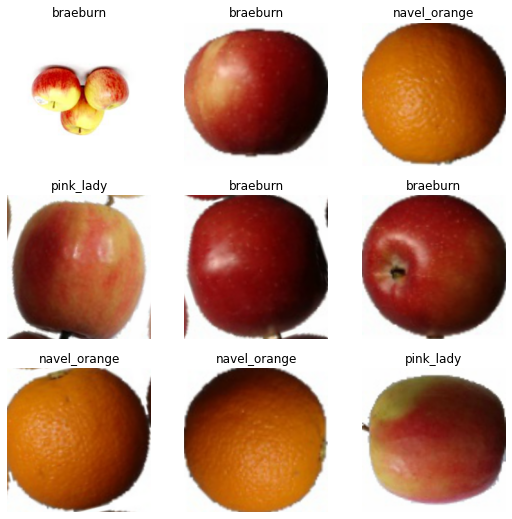

In [22]:
# Preview data
dls.show_batch()

In [23]:
# Init learner; use resnet50 as the starting point for this CNN
learn = cnn_learner(dls, resnet152, metrics=partial(accuracy_multi, thresh=0.5))

SuggestedLRs(valley=0.0008317637839354575)

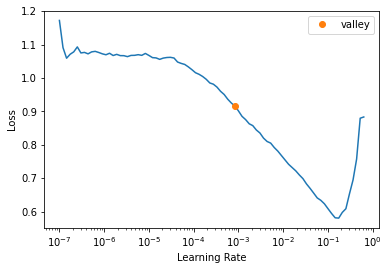

In [24]:
# Calc optimal learning rate
learn.lr_find()

In [ ]:
# Train model
learn.fine_tune(8, 0.000832)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.568106,0.229635,0.904792,17:23


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.352742,0.263772,0.871565,21:46
1,0.305014,0.174042,0.952716,21:43
2,0.246248,0.123390,0.973802,22:06


In [ ]:
# Preview results
learn.show_results()